# Oil Price Analysis

Import neccessary libraries and modules

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import os, sys
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from data_preprocessor import DataPreprocessor  

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

**Data Collection**

- Download the brent oil price data

In [3]:
# Set google drive url for loading the dataset
url = 'https://drive.google.com/file/d/1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5/view?usp=drive_link'

# Setup the data preprocessor class
processor = DataPreprocessor(url, logger=logger)
# Load the data
price_data = processor.load_data()

Downloading...
From: https://drive.google.com/uc?export=download&id=1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5
To: /home/noh/10Academy/oil-price-statistical-modeling/data/data.csv
100%|██████████| 156k/156k [00:00<00:00, 291kB/s]


**Note**: always check `logs/notebooks.log` file for any log messages

In [4]:
# Explore the first 10 rows
price_data.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [5]:
# Explore the last 10 rows
price_data.tail(10)

,Price
Date,
2022-11-01,95.12
2022-11-02,96.07
2022-11-03,95.29
2022-11-04,99.53
2022-11-07,99.87
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37


Create event dataset collected from various sources

In [30]:
# Define the events dictionary with categories
events_dict = {
    "Gulf War (1990-1991)": {"start": "1990-08-02", "end": "1991-02-28", "category": "Geopolitical Conflicts"},
    "September 11 Attacks (2001)": {"start": "2001-09-11", "end": "2001-09-11", "category": "Geopolitical Conflicts"},
    "2003 Invasion of Iraq": {"start": "2003-03-20", "end": "2011-12-18", "category": "Geopolitical Conflicts"},
    "2008 Financial Crisis": {"start": "2008-09-15", "end": "2009-07-01", "category": "Economic Crises"},
    "Arab Spring (2010-2012)": {"start": "2010-12-18", "end": "2012-12-18", "category": "Geopolitical Conflicts"},
    "Libyan Civil War (2011)": {"start": "2011-02-15", "end": "2011-10-23", "category": "Geopolitical Conflicts"},
    "U.S. Shale Oil Boom (2010s)": {"start": "2010-01-01", "end": "2019-12-31", "category": "Technological Advances"},
    "OPEC Production Cuts (2016-2017)": {"start": "2016-11-30", "end": "2017-06-30", "category": "OPEC Policies"},
    "Iran Nuclear Deal and Sanctions (2015-2018)": {"start": "2015-07-14", "end": "2018-05-07", "category": "OPEC Policies"},
    "COVID-19 Pandemic (2020)": {"start": "2020-03-11", "end": "2022-09-30", "category": "Economic Crises"},
    "OPEC+ Response to COVID-19 (2020)": {"start": "2020-04-09", "end": "2020-12-31", "category": "OPEC Policies"},
    "Russia-Ukraine Conflict (2022)": {"start": "2022-02-24", "end": "2022-09-30", "category": "Geopolitical Conflicts"},
    "Global Economic Recovery (2021-2022)": {"start": "2021-01-01", "end": "2022-09-30", "category": "Economic Crises"}
}

# Convert the events dictionary to a DataFrame
events_data = pd.DataFrame.from_dict(events_dict, orient='index')
events_data.reset_index(inplace=True)
events_data.columns = ['Event', 'Start', 'End', 'Category']

# Convert Start and End to datetime
events_data['Start'] = pd.to_datetime(events_data['Start'])
events_data['End'] = pd.to_datetime(events_data['End'])


In [31]:
events_data

,Event,Start,End,Category
0,Gulf War (1990-1991),1990-08-02,1991-02-28,Geopolitical Conflicts
1,September 11 Attacks (2001),2001-09-11,2001-09-11,Geopolitical Conflicts
2,2003 Invasion of Iraq,2003-03-20,2011-12-18,Geopolitical Conflicts
3,2008 Financial Crisis,2008-09-15,2009-07-01,Economic Crises
4,Arab Spring (2010-2012),2010-12-18,2012-12-18,Geopolitical Conflicts
5,Libyan Civil War (2011),2011-02-15,2011-10-23,Geopolitical Conflicts
6,U.S. Shale Oil Boom (2010s),2010-01-01,2019-12-31,Technological Advances
7,OPEC Production Cuts (2016-2017),2016-11-30,2017-06-30,OPEC Policies
8,Iran Nuclear Deal and Sanctions (2015-2018),2015-07-14,2018-05-07,OPEC Policies
9,COVID-19 Pandemic (2020),2020-03-11,2022-09-30,Economic Crises


Combine the price data with event data

In [32]:
def merge_event(events_data: pd.DataFrame, price_data: pd.DataFrame) -> pd.DataFrame:
    # Ensure Date, Start, and End columns are in datetime format
    price_data['Date'] = pd.to_datetime(price_data['Date'])
    events_data['Start'] = pd.to_datetime(events_data['Start'])
    events_data['End'] = pd.to_datetime(events_data['End'])

    # Create a DataFrame that contains each price date with corresponding events
    events_expanded = pd.DataFrame({
        'Date': pd.date_range(start=events_data['Start'].min(), end=events_data['End'].max(), freq='D')
    })

    # Merge expanded dates with the events data to bring over both Event and Category
    merged_data = pd.merge_asof(
        events_expanded.sort_values('Date'), 
        events_data.sort_values('Start'), 
        left_on='Date', 
        right_on='Start', 
        direction='backward'
    )

    # Merge the price data with the merged event data
    price_data = price_data.merge(merged_data[['Date', 'Event', 'Category']], on='Date', how='left')

    # Fill 'Event' and 'Category' columns with 'No Event' where there is no match
    price_data.fillna({'Event': 'No Event', 'Category': 'No Category'}, inplace=True)

    return price_data

# Apply the function to merge events with each price date
price_data = merge_event(events_data, price_data)


In [33]:

# Now price_data contains the original price data along with the corresponding events
price_data.head(10)  # View the combined data


,Date,Price,Event,Category
0,1987-05-20,18.63,No Event,No Category
1,1987-05-21,18.45,No Event,No Category
2,1987-05-22,18.55,No Event,No Category
3,1987-05-25,18.60,No Event,No Category
4,1987-05-26,18.63,No Event,No Category
5,1987-05-27,18.60,No Event,No Category
6,1987-05-28,18.60,No Event,No Category
7,1987-05-29,18.58,No Event,No Category
8,1987-06-01,18.65,No Event,No Category
9,1987-06-02,18.68,No Event,No Category


In [5]:
price_data.iloc[8011:8021]

,Price
Date,
2018-12-07,61.71
2018-12-10,60.29
2018-12-11,59.73
2018-12-12,59.94
2018-12-13,59.03
2018-12-14,58.56
2018-12-17,57.59
2018-12-18,55.26
2018-12-19,55.60


### Data Cleaning and Preprocessing

Inspect the dataset for completeness and structure

In [6]:
processor.inspect(price_data)

Dimensions (rows, columns): (9011, 2)

Data Types:
Date     datetime64[ns]
Price           float64
dtype: object

No missing values found.

Unique Values in Each Column:
Date     9011
Price    5015
dtype: int64
Number of duplicate rows: 0

Summary Statistics for Numeric Columns:


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


**Detect Outliers**

- Box plot

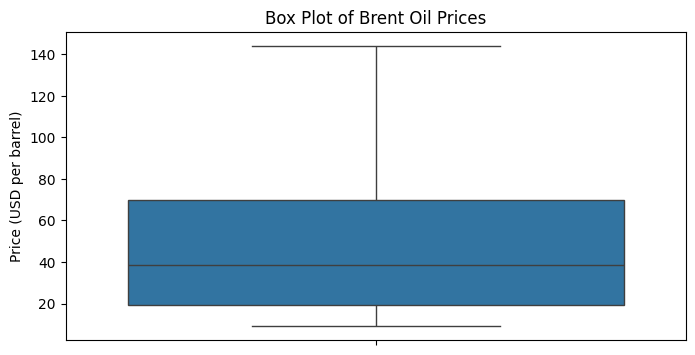

In [7]:
# Assuming 'price_data' is your DataFrame containing the 'Price' column
plt.figure(figsize=(8, 4))
sns.boxplot(data=price_data, y='Price')
plt.title('Box Plot of Brent Oil Prices')
plt.ylabel('Price (USD per barrel)')
plt.show()

- No outliers detected in the price data

### Exploratory Data Analysis

- Descriptive Statistics

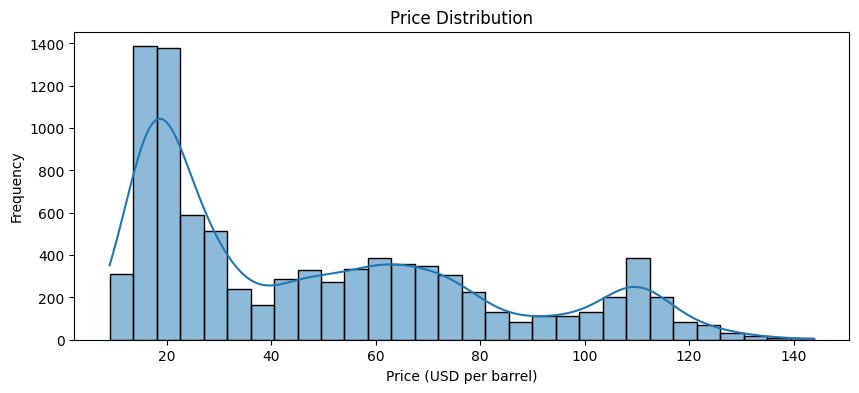

In [8]:
# Visualize the price distribution
plt.figure(figsize=(10, 4))
sns.histplot(price_data['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (USD per barrel)')
plt.ylabel('Frequency')
plt.show()


**Time Series Analysis**
- Overall price trend

    - Create a line graph to visualize price trends over time.

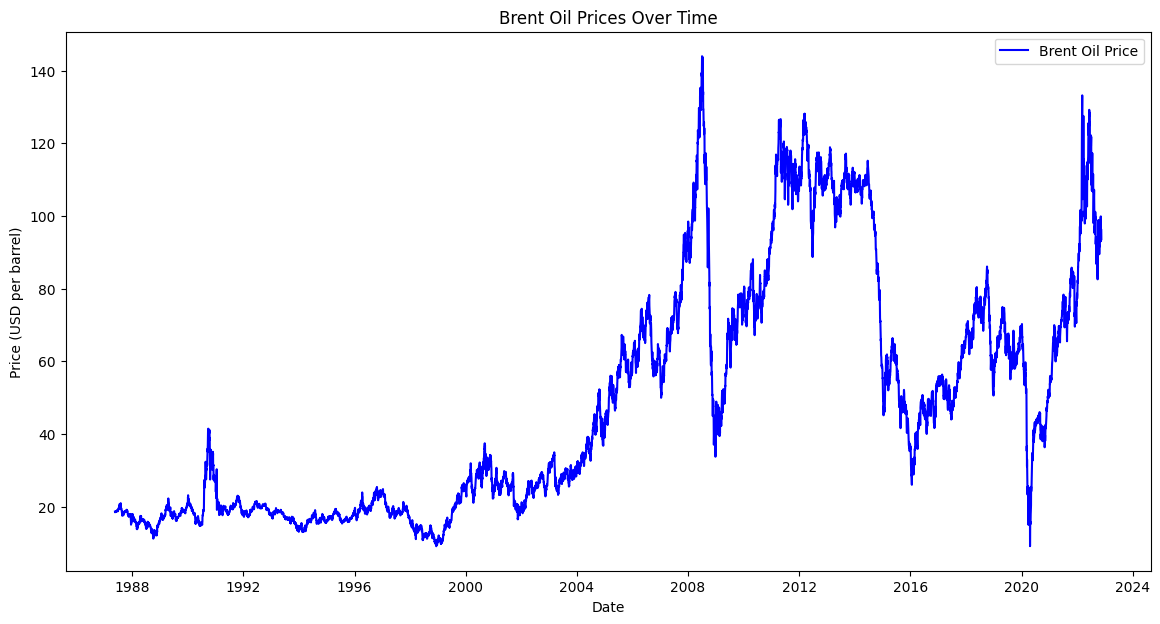

In [9]:
plt.plot(price_data.index, price_data['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
# plt.axvline(x='Date', color='red', linestyle='--', label='Event Marker')
plt.legend()
plt.show()


- **Seasonality Analysis**
    - Aggregate prices by year and visualize seasonal patterns.

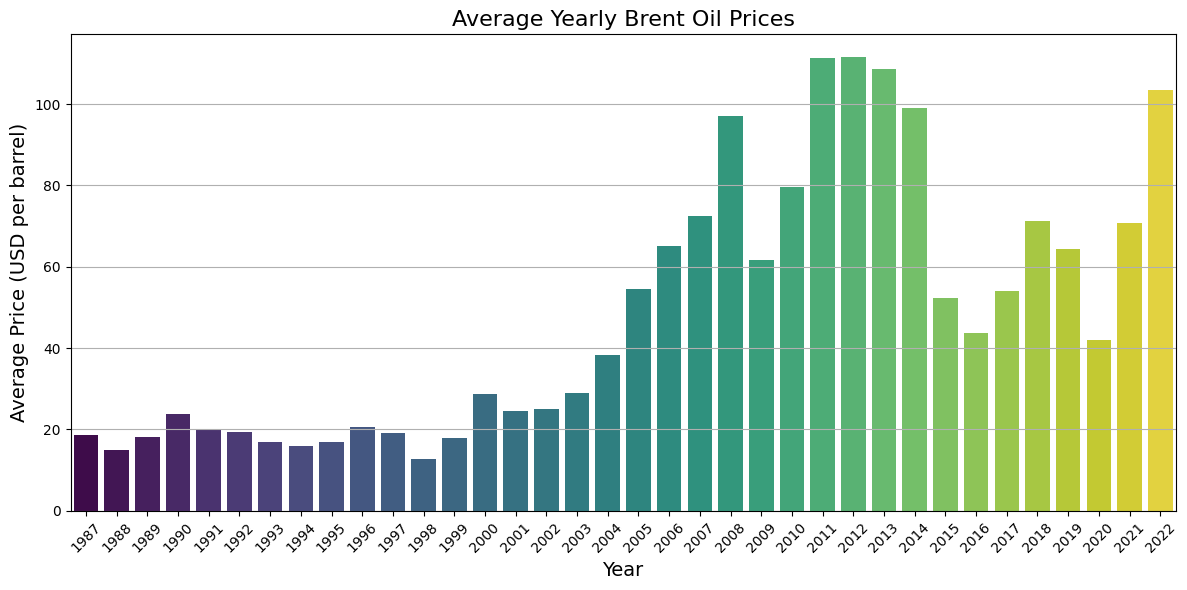

In [10]:
# Extract the year from the Date
df = price_data.copy().reset_index()

df['Year'] = df['Date'].dt.year

# Calculate average price per year
yearly_avg = df.groupby('Year')['Price'].mean().reset_index()

# Plot yearly average prices
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Price', data=yearly_avg, hue='Year', legend=False, palette='viridis')
plt.title('Average Yearly Brent Oil Prices', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Price (USD per barrel)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- **Rolling Volatility Analysis**

    - Rolling standard deviation (e.g., 30-day) line plot of prices.

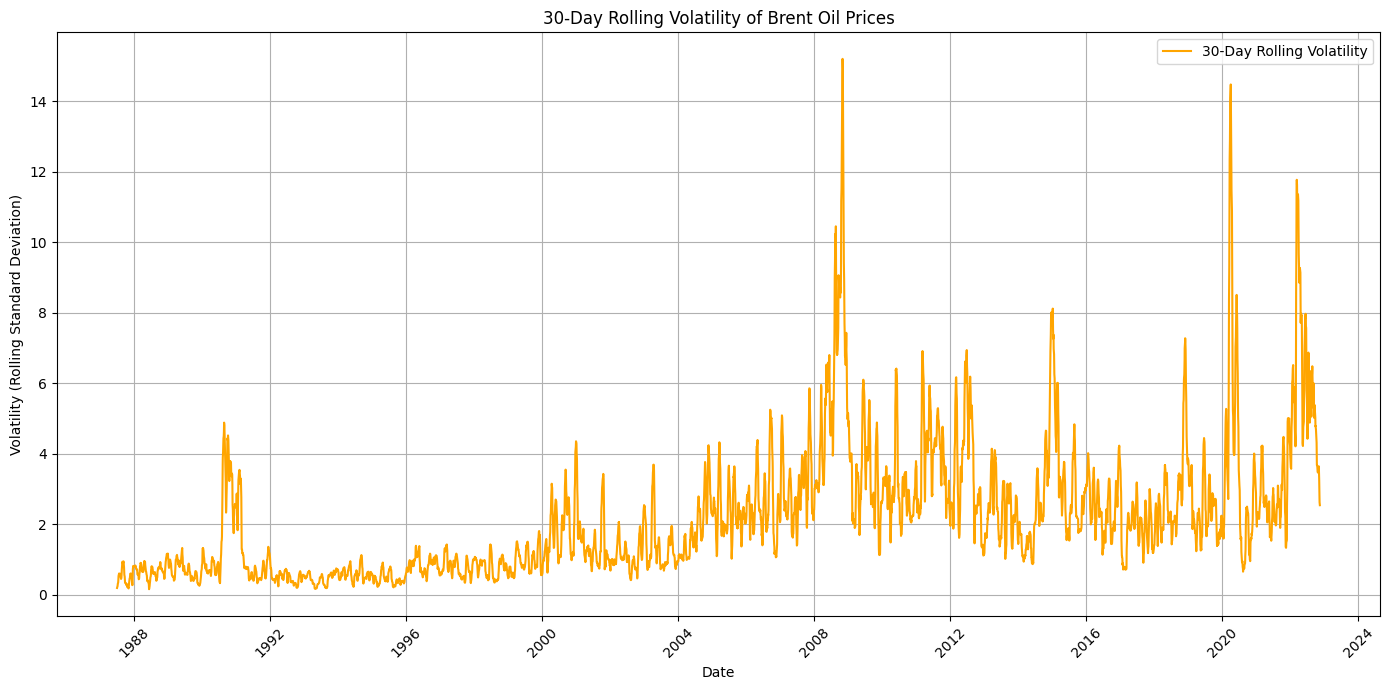

In [12]:
def plot_rolling_volatility(price_data, window=30):
    """
    Plot the rolling standard deviation (volatility) of oil prices over a specified window.
    
    Parameters:
    - price_data (pd.DataFrame): DataFrame with 'Date' and 'Price' columns.
    - window (int): The rolling window size in days (default is 30).
    """
    # Calculate rolling standard deviation (volatility)
    price_data['Rolling_Volatility'] = price_data['Price'].rolling(window=window).std()
    
    # Plot
    plt.plot(price_data.index, price_data['Rolling_Volatility'], label=f'{window}-Day Rolling Volatility', color='orange')
    
    # Label and style the plot
    plt.title(f'{window}-Day Rolling Volatility of Brent Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Volatility (Rolling Standard Deviation)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function
plot_rolling_volatility(price_data)

**Seasonal Decomposition**

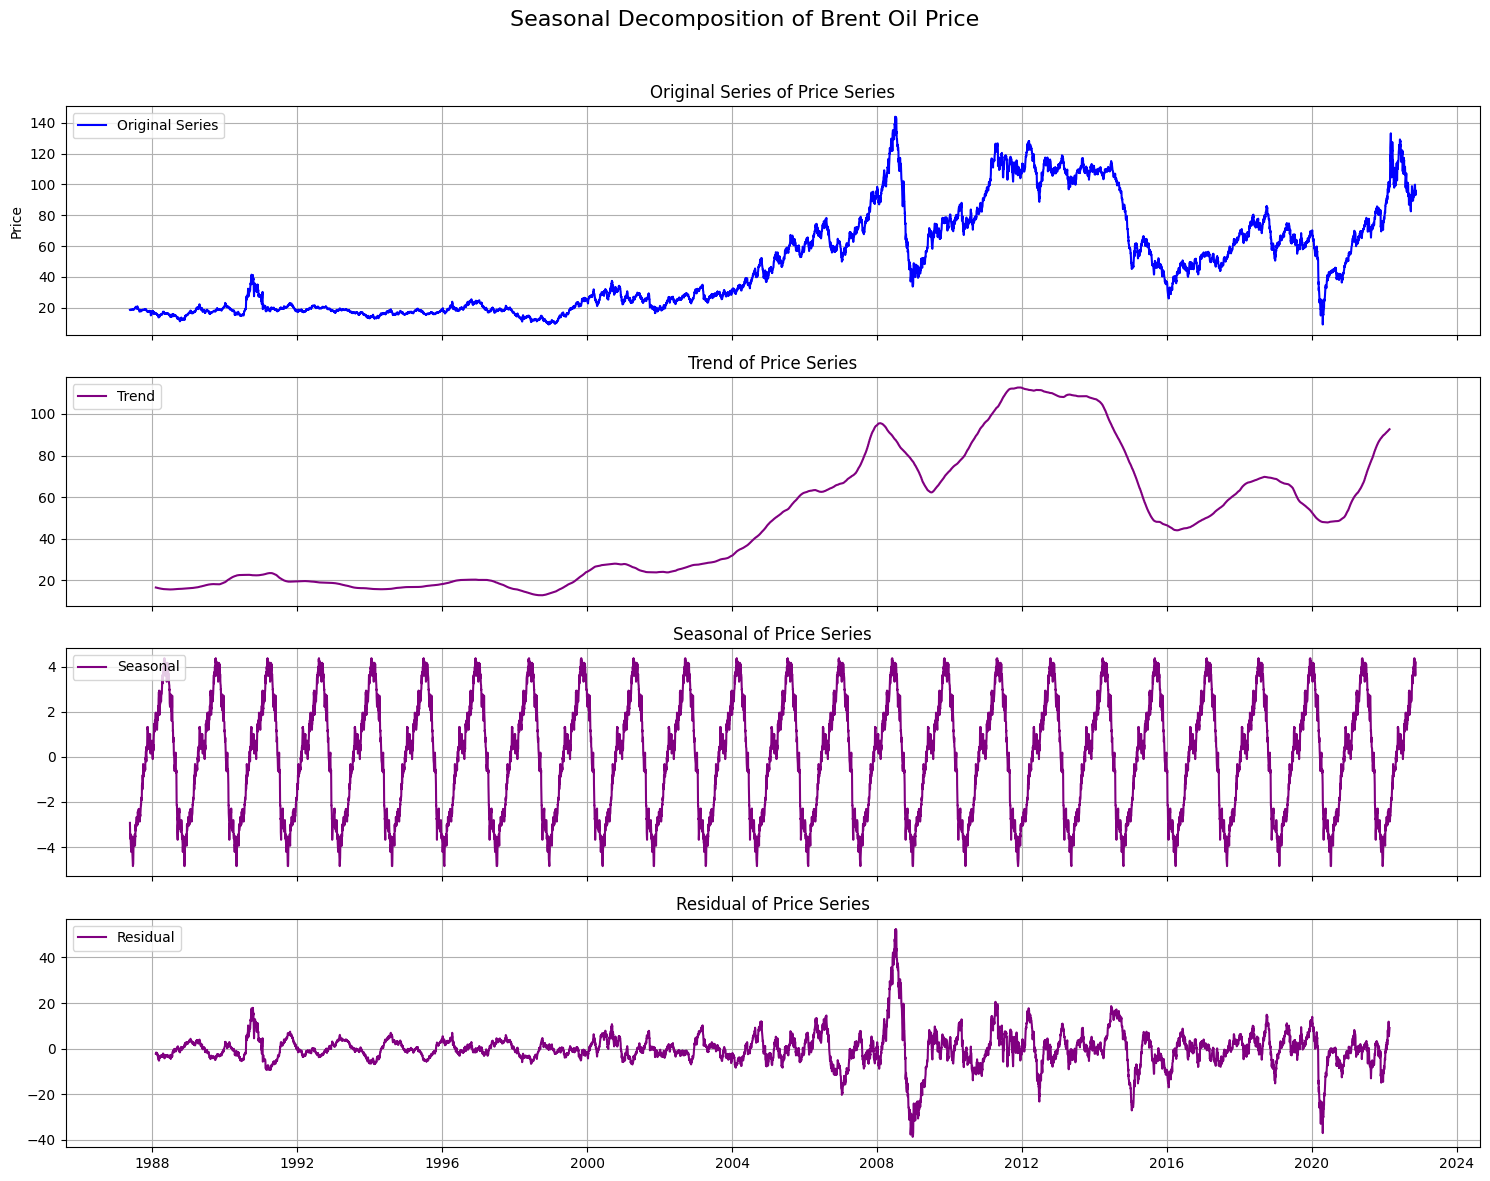

In [13]:
# Apply seasonal decomposition (use model='multiplicative' for data with proportional seasonal effects)
result = seasonal_decompose(price_data['Price'], model='additive', period=365)  # Adjust period if necessary

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
components = ['Original Series', 'Trend', 'Seasonal', 'Residual']
series = [price_data['Price'], result.trend, result.seasonal, result.resid]

for ax, comp, ser in zip(axes, components, series):
    ax.plot(price_data.index, ser, label=comp, color='b' if comp == 'Original Series' else 'purple')
    ax.set_title(f'{comp} of Price Series')
    ax.set_ylabel('Price' if comp == 'Original Series' else '')
    ax.grid(True)
    ax.legend(loc='upper left')

# Improve layout and display the plot
fig.suptitle('Seasonal Decomposition of Brent Oil Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

**Stationaly Analysis of Time Series Data**

- Apply the Augmented Dickey-Fuller (ADF) Test

ADF Statistic: -15.529367580048012
p-value: 2.2307405105163768e-28
Critical Values:
   1%: -3.4310783342658615
   5%: -2.861861876398633
   10%: -2.566941329781918
The ADF test suggests the series is stationary.


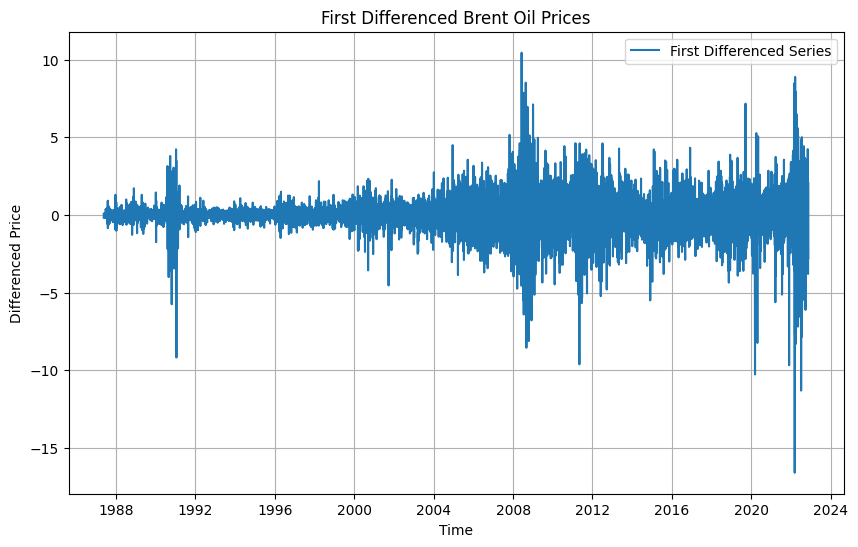

(-15.529367580048012, 2.2307405105163768e-28)

In [15]:
def test_stationarity(series, title, label, alpha=0.05):
    adf_result = adfuller(series)
    
    # Print ADF results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')
    
    # Interpretation
    if adf_result[1] < alpha:
        print("The ADF test suggests the series is stationary.")
    else:
        print("The ADF test suggests the series is not stationary.")

    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(series, label=label)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return adf_result[0], adf_result[1]  # Returning ADF statistic and p-value for further use

# Assuming 'price_data' is your DataFrame with a 'Price' column
data = price_data['Price']

# First differencing
data_diff = data.diff().dropna()
test_stationarity(data_diff, title='First Differenced Brent Oil Prices', label='First Differenced Series')

### Event Specific Change Analysis

CUSUM Analysis

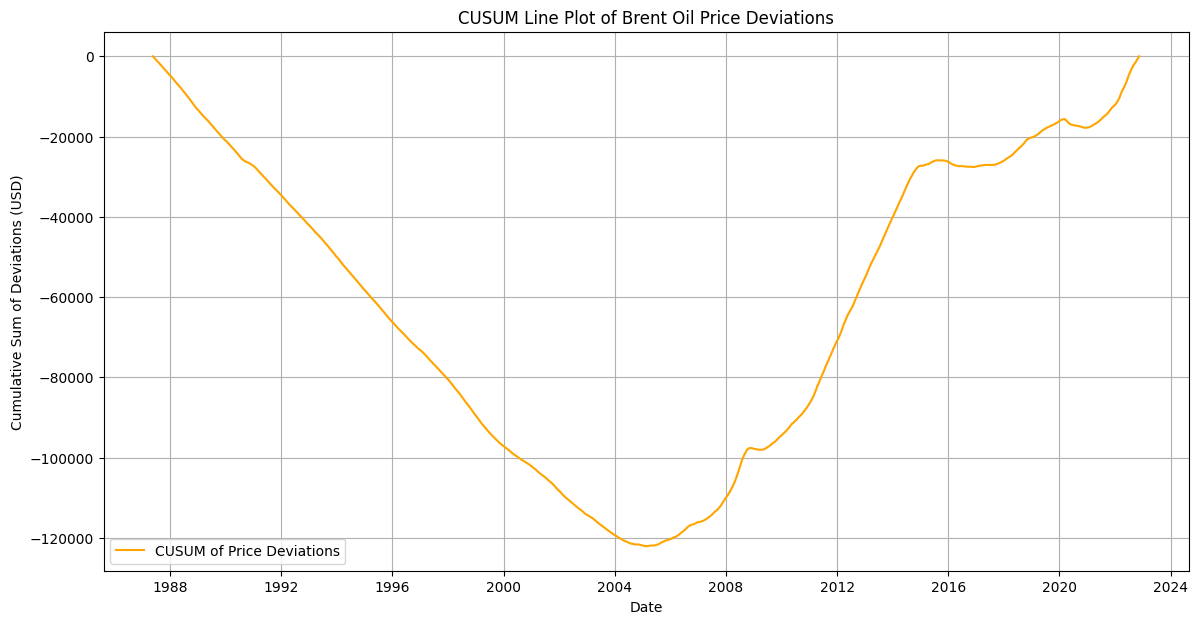

In [12]:
# Calculate CUSUM (Cumulative Sum of Deviations from Mean)
mean_price = price_data['Price'].mean()
cusum = (price_data['Price'] - mean_price).cumsum()

# Plotting the CUSUM line plot
plt.plot(price_data.index, cusum, label='CUSUM of Price Deviations', color='orange')

# Enhancements for better readability
plt.title('CUSUM Line Plot of Brent Oil Price Deviations')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum of Deviations (USD)')
plt.legend()
plt.grid()
plt.show()

**Change Point Analysis with CUSUM**

Detected change point years: [1999, 2005, 2010, 2014, 2021]


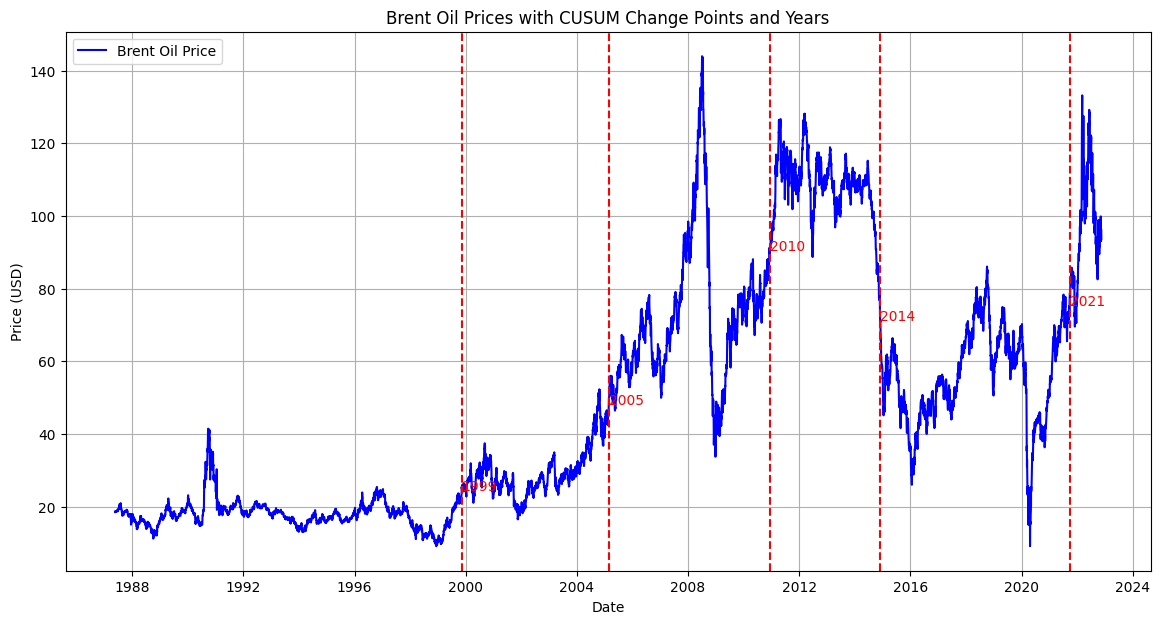

In [63]:
import ruptures as rpt

# Extract the price series for change point detection
price_df = price_data.reset_index()
price_series = price_df['Price'].values

# Apply the CUSUM-based method for change point detection
algo = rpt.Binseg(model="l2").fit(price_series)
change_points = algo.predict(n_bkps=5)  # Adjust n_bkps for more or fewer breakpoints

# Extract and print the year of each change point
change_years = [price_df['Date'].iloc[cp].year for cp in change_points[:-1]]  # Exclude the last index (end of data)
print("Detected change point years:", change_years)

# Plotting the Brent Oil Price with change points
plt.plot(price_df['Date'], price_df['Price'], label='Brent Oil Price', color='blue')

# Overlay detected change points with year annotations
for cp in change_points[:-1]:  # Exclude the last point (end of data)
    year = price_df['Date'].iloc[cp].year
    plt.axvline(price_df['Date'].iloc[cp], color='red', linestyle='--')
    plt.text(price_df['Date'].iloc[cp], price_data['Price'].iloc[cp], str(year), color="red", fontsize=10)

# Enhancements
plt.title('Brent Oil Prices with CUSUM Change Points and Years')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

Baysian Change Point Detection

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mean_prior1, mean_prior2, sigma1, sigma2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


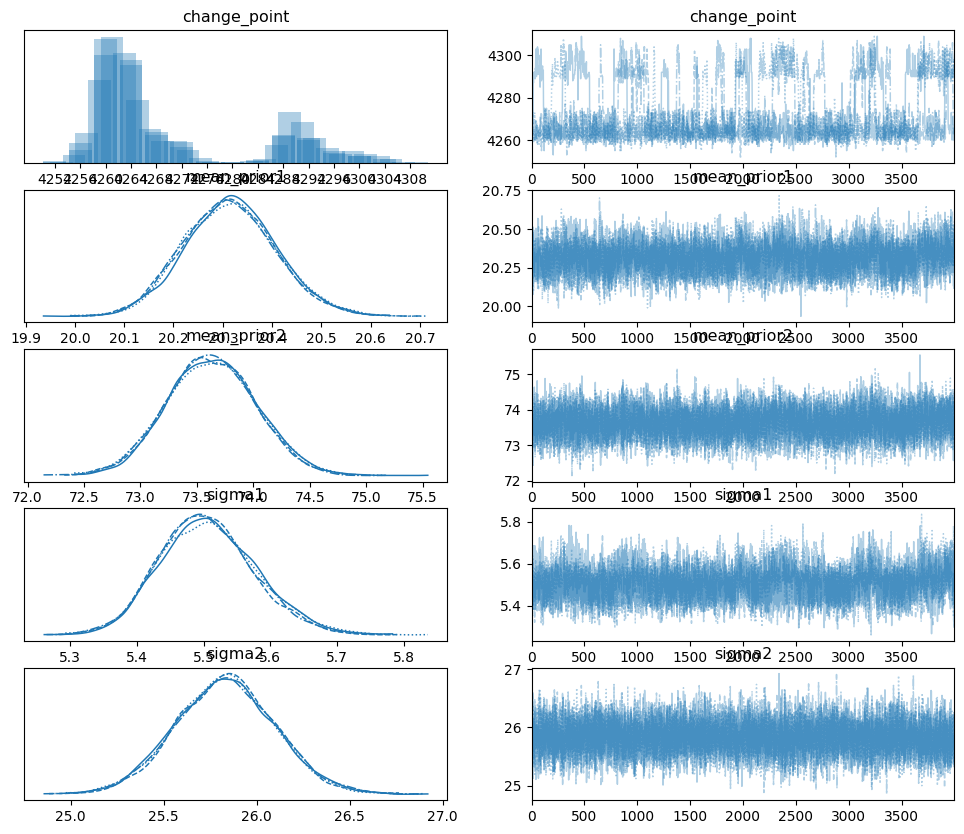

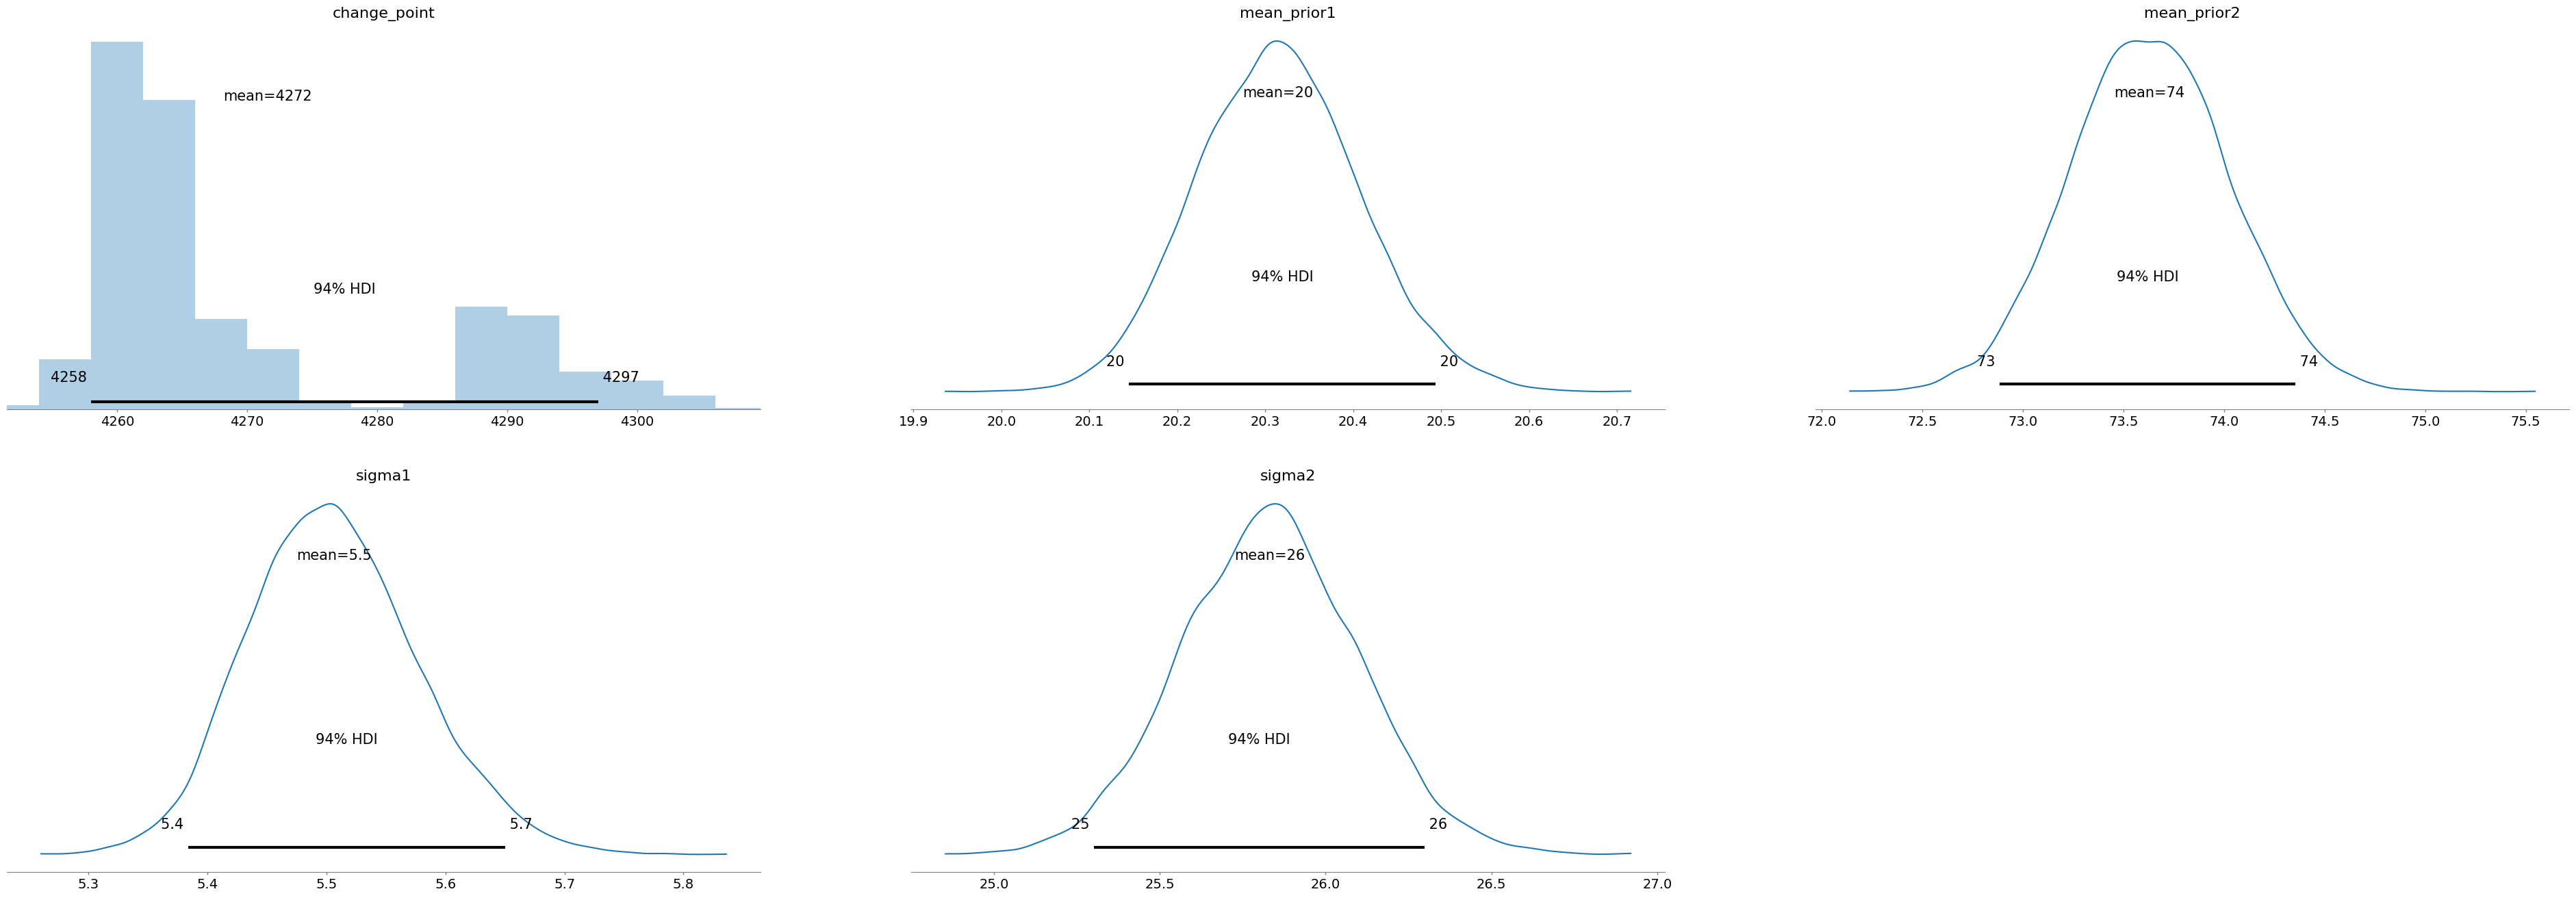

Estimated Change Point Date: 2004-03-02 00:00:00
95% HDI for the Change Point: [4257 4298]


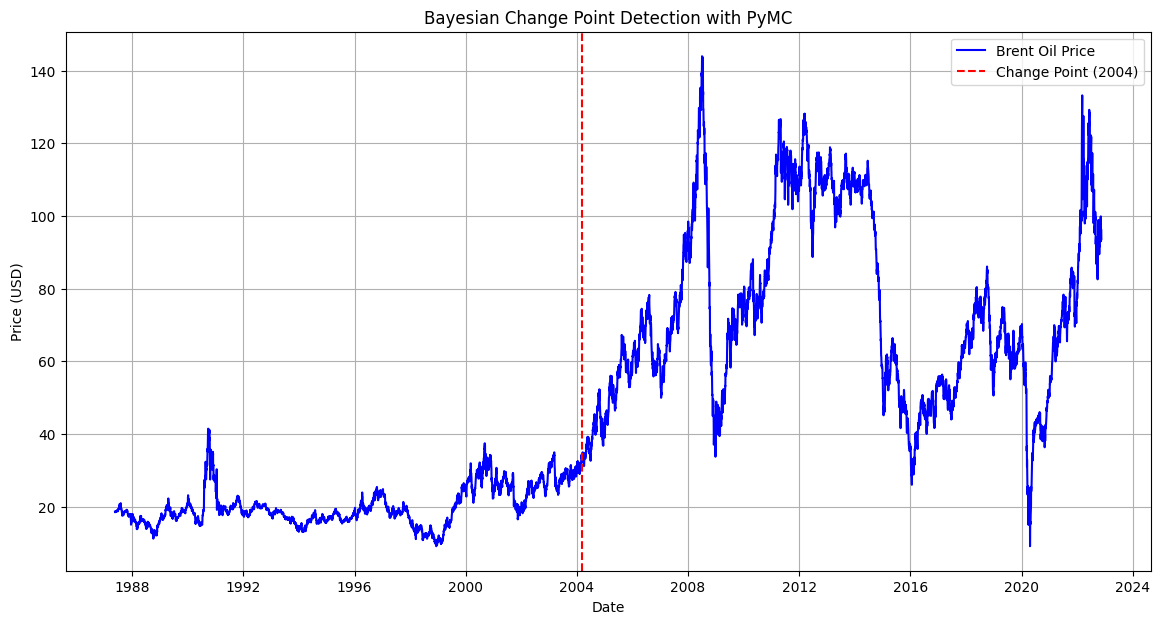

In [67]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Load your price data (Assuming 'price_data' is a DataFrame with 'Date' as index and 'Price' as column)

# Extract price values for modeling
data = price_data['Price'].values

# Set informative mean priors based on analysis of data
prior_mu1 = np.mean(data)  # Prior mean for the first segment
prior_mu2 = np.mean(data)  # Prior mean for the second segment

with pm.Model() as model:
    # Define the change point
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(data) - 1)

    # Segment-specific means and standard deviations
    mu1 = pm.Normal('mean_prior1', mu=prior_mu1, sigma=5)  # Mean for segment 1
    mu2 = pm.Normal('mean_prior2', mu=prior_mu2, sigma=5)  # Mean for segment 2
    sigma1 = pm.HalfNormal('sigma1', sigma=5)  # Std deviation for segment 1
    sigma2 = pm.HalfNormal('sigma2', sigma=5)  # Std deviation for segment 2

    # Likelihood with switching behavior at change point
    likelihood = pm.Normal('likelihood',
                           mu=pm.math.switch(change_point >= np.arange(len(data)), mu1, mu2),
                           sigma=pm.math.switch(change_point >= np.arange(len(data)), sigma1, sigma2),
                           observed=data)

    # Sample from the posterior
    trace = pm.sample(4000, tune=2000, chains=4, random_seed=42)
    
# Plot convergence diagnostics
az.plot_trace(trace)

# Plot posterior distributions
pm.plot_posterior(trace)
plt.show()

# Analyze the change point
s_posterior = trace.posterior['change_point'].values.flatten()
estimated_change_point = int(np.median(s_posterior))

# Map change point index back to date
change_point_date = price_data.index[estimated_change_point]
print(f"Estimated Change Point Date: {change_point_date}")

# Calculate 95% HDI for the change point
hdi = az.hdi(s_posterior, hdi_prob=0.95)
print(f"95% HDI for the Change Point: {hdi}")

# Visualize the change point on the price data
plt.plot(price_data.index, data, label='Brent Oil Price', color='blue')
plt.axvline(change_point_date, color='red', linestyle='--', label=f'Change Point ({change_point_date.year})')
plt.title('Bayesian Change Point Detection with PyMC')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


- **Box Plot of Price Distributions by Segment**

    - Box plots can be created for each segment between change points, giving insights into the distribution characteristics within each period, both before and after each shift.

/tmp/ipykernel_102419/1514049026.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y='Price', data=price_data.reset_index(), palette="Set3")


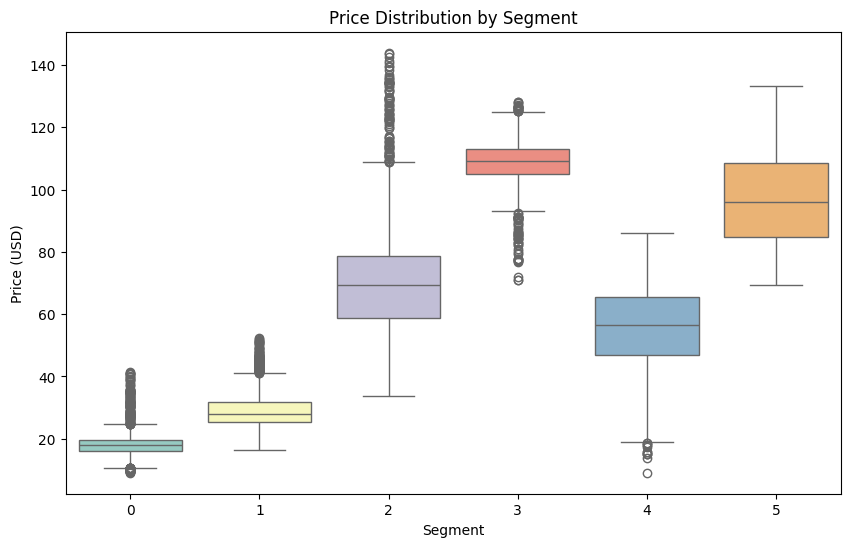

In [27]:
# Box Plot of Price Distributions by Segment
# Convert change_points from indexes to dates
change_point_dates = price_data.index[change_points[:-1]]

# Create a 'Segment' column based on change points
price_data['Segment'] = 0
for i, cp in enumerate(change_point_dates):
    price_data.loc[price_data.index > cp, 'Segment'] = i + 1

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Price', data=price_data.reset_index(), palette="Set3")
plt.title('Price Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Price (USD)')
plt.show()